In [1]:
from scipy.io import loadmat
import numpy as np 
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
from scipy.sparse.linalg import svds, bicg, inv, LinearOperator
from scipy.sparse import diags
from scipy.linalg import pinv

# 1 X-ray tomography

In [2]:
H = loadmat('data/H.mat')['H']
x = loadmat('data/x.mat')['x']
G = loadmat('data/G.mat')['G']

In [3]:
hx = H@x
y = hx + np.random.normal(size = hx.shape, scale=1)

In [4]:
y_view = y.reshape((90,180), order='F')
x_view = x.reshape((90,90), order='F')

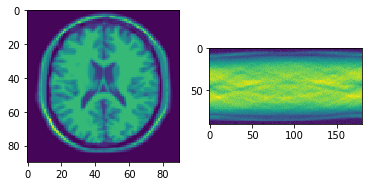

In [5]:
fg , ax = plt.subplots(1,2)
ax[0].imshow(x_view)
ax[1].imshow(y_view)

# 2 Optimization problem

Given that $$\left(\forall x \in \mathbb{R}^{N}\right) \quad f(x)=\frac{1}{2}\|H x-y\|^{2}+\lambda r(x)$$

With, $$\left(\forall x \in \mathbb{R}^{N}\right) \quad r(x)=\sum_{n=1}^{2 N} \psi\left([G x]^{(n)}\right)$$

With, $$\left(\forall u \in \mathbb{R}\right) \quad \psi(u)=\sqrt{1+\frac{u^{2}}{\delta^{2}}}$$

---

One has :$$\left(\forall x \in \mathbb{R}^{N}\right) \quad \nabla f=H^{\top} H x - H^{\top} y + \lambda \nabla r(x)$$
$$\left(\forall x \in \mathbb{R}^{N}\right) \quad \lambda\nabla r = \lambda G^{\top}\psi^{\prime}(G x)$$
with $$\psi^{\prime}(u)=\frac{u}{\delta^{2} \sqrt{1+\frac{u^{2}}{\delta^{2}}}}$$ applied to each component of $G x$.

In [6]:
def r(x):
    return np.sum(np.sqrt(1 + G.dot(x) ** 2 / ( delta ** 2 )))

def f(x, y, lambda_): 
    return(1/2 * np.linalg.norm(H@x - y, ord=2) + lambda_ * r(x))

In [7]:
lambda_ , delta = 0.13, 0.02

In [8]:
def grad_f(x): 
    return(H.T @ (H @ x) - H.T @ y + lambda_ * G.T @ grad_psi(G @ x))

def grad_psi(u, delta=delta): 
    return(u / ( delta ** 2 * np.sqrt(1 + u ** 2 / ( delta ** 2 ))))

def h(x): 
    
    return(f(x_n) + np.dot(grad_f(x_n), x - x_n) + 1/2 * np.sqrt(np.dot(x - x_n, A @ (x - x_n))))

Moreover, given that :$$\nabla f=H^{\top} H x-H^{\top} y+\lambda G^{\top} \Psi^{\prime}(G x)$$
One has, 
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| = \left\|H^{\top} H (x_{1}-x_{2}) + \lambda G^{\top} \psi^{\prime}(G x_{1}) - \psi^{\prime}(G x_{2}) \right\|$$
Thus with $\lambda>0$ and using the triangle inequality, 
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\|\leq \left\|H^{\top} H (x_{1}-x_{2})\right\| + \lambda \left\|G^{\top}\psi^{\prime}(G x_{1}) - G^{\top}\psi^{\prime}(G x_{2})\right\|$$
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\|\leq \left\|H^{\top} H (x_{1}-x_{2})\right\| + \lambda \left\|G\right\| \left\|\psi^{\prime}(G x_{1}) - \psi^{\prime}(G x_{2})\right\|$$
Then by the fact that $$\left(\forall u \in \mathbb{R}\right) \quad \left\|\psi^{\prime}(u)\right\|=\left\|\frac{u}{\delta^{2} \sqrt{1+\frac{u^{2}}{\delta^{2}}}}\right\| \leq \left\|\frac{u}{\delta^{2}}\right\|$$ we know that $\frac{1}{\delta^{2}}$ is a Lipschitz constant of $\psi^{\prime}$.
And thus, $$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| \leq \left\|H\right\|^{2} \left\|x_{1}-x_{2}\right\| + \lambda \left\|G\right\| \frac{1}{\delta^{2}} \left\|G x_{1} - G x_{2}\right\|$$
And finally : $$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| \leq \left(\left\|H\right\|^{2}+ \frac{\lambda}{\delta^{2}} \left\|G\right\|^{2}\right) \left\|x_{1} - x_{2}\right\|$$

Thus, $L=\|H\|^{2}+\left(\lambda / \delta^{2}\right)\|G\|^{2}$ is a Lipschitz constant of $\nabla f$, which for $(\lambda, \delta)=(0.13,0.02)$ gives $L=1.809e+04$.

Detailed computation of L in this case :

In [9]:
def lipschitz_constant(G,H, lambda_=0.13, delta=0.02):
    _, singular_value_G, _ = svds(G)
    _, singular_value_H, _ = svds(H)
    return(max(singular_value_H) ** 2 + (lambda_ / (delta ** 2 )) * (max(singular_value_G)**2))

In [10]:
print("The lipschitz constant of the gradient of f is : {:.3e}".format(lipschitz_constant(G,H)))

The lipschitz constant of the gradient of f is : 1.809e+04


# 3 Optimization algorithms
## 3.1 Gradient Descent Algorithm 

In [11]:
M, N = 90 * 180, 90 * 90 
x_0 = np.zeros((N,1))

Error : 4.4950e+01 | value of f : 3324.8306 | rec_error : 23.0919
Error : 4.2894e-01 | value of f : 3517.8006 | rec_error : 8.7844
Error : 2.0147e-01 | value of f : 4200.2033 | rec_error : 6.6583
Error : 1.2492e-01 | value of f : 4639.8413 | rec_error : 5.4969
Error : 8.3686e-02 | value of f : 4932.6960 | rec_error : 4.8121
Error : 5.9158e-02 | value of f : 5133.2045 | rec_error : 4.3939
Error : 4.3652e-02 | value of f : 5273.6553 | rec_error : 4.1334
Error : 3.3412e-02 | value of f : 5373.8638 | rec_error : 3.9695
Error : 2.6398e-02 | value of f : 5446.5314 | rec_error : 3.8665
Error : 2.1427e-02 | value of f : 5500.0599 | rec_error : 3.8027
Error : 1.7796e-02 | value of f : 5540.0977 | rec_error : 3.7645
Error : 1.5072e-02 | value of f : 5570.4709 | rec_error : 3.7434
Error : 1.2975e-02 | value of f : 5593.8074 | rec_error : 3.7337
Error : 1.1319e-02 | value of f : 5611.9507 | rec_error : 3.7317
Error : 9.9795e-03 | value of f : 5626.2146 | rec_error : 3.7348
Error : 8.8779e-03 | val

Text(0.5, 1.0, 'Reconstruction result, Gradient Descent algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, standardized_error=1.1356e-01')

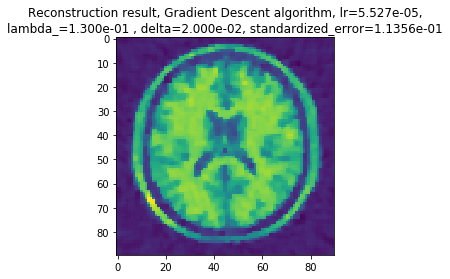

In [57]:
learning_rate = 1/lipschitz_constant(G,H)
def grad_desc(lambda_=lambda_, delta=delta, learning_rate=1e-4, eps=1e-6, max_iter=1000,
              stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        x_n1 = x_n - learning_rate * grad
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append(error)
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_n = x_n1.copy()
        itr+=1

    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))
    
    return x_n, error, history
    
x_rec_GD, _, history_GD = grad_desc()
error_GD = np.linalg.norm((x - x_rec_GD).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_GD_view = x_rec_GD.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_GD_view)
ax.set_title('Reconstruction result, Gradient Descent algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, standardized_error={2:.4e}'.format(lambda_, delta, error_GD))

## 3.2 MM quadratic algorithm

For every $y \in \mathbb{R}^{N}$ we will look for a self-adjoint operator A such that :$$(\forall x \in \mathbb{R}^{N}) \quad h(x, y)=f(y)+\langle\nabla f(y) | x-y\rangle+\frac{1}{2}\|x-y\|_{A(y)}^{2}$$ is a majorant function of f at y.

We will construct $\Delta$ such that :$$(\forall x \in \mathbb{R}^{N}) \quad \Delta=\operatorname{diag}\left\{\frac{\psi^{\prime}(x_{i})}{x_{i}}\right\}_{i \in \{1, \ldots, N\}}$$ because $\psi(\sqrt{.})$ is concave, $\psi$ is positive and $\lim_{u \to 0^{+}} \frac{\psi(u)}{u}$ is finite.

And then we choose A as : $$(\forall x \in \mathbb{R}^{N}) \quad A(x)=H^{\top}H + \lambda G^{\top} \Delta(G x) G$$

In [16]:
diags((grad_psi(x)/x).flatten()).tocsc()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<8100x8100 sparse matrix of type '<class 'numpy.float64'>'
	with 8100 stored elements in Compressed Sparse Column format>

In [17]:
def big_delta(x, delta, eps = 1e-10):
    return diags((grad_psi(x, delta)/(x+eps)).flatten()).tocsc()

Error : 3.6496e+01 | value of f : 14506.3030 | rec_error : 9.2512
Error : 5.4580e-02 | value of f : 5709.8817 | rec_error : 3.9720
Error : 9.5893e-03 | value of f : 5694.2745 | rec_error : 4.0062
Error : 2.3877e-03 | value of f : 5692.3628 | rec_error : 4.0116
Error : 6.6893e-04 | value of f : 5691.9827 | rec_error : 4.0128
Error : 2.0109e-04 | value of f : 5691.8910 | rec_error : 4.0130
Error : 6.4124e-05 | value of f : 5691.8667 | rec_error : 4.0131
It took 67 iterations and 42.28 seconds to converge.


Text(0.5, 1.0, 'Reconstruction result, MM_quad algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, error=1.1371e-01')

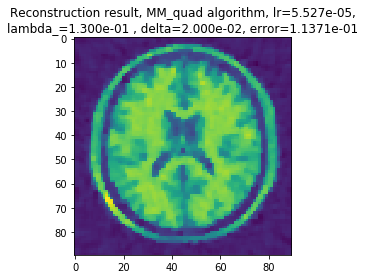

In [61]:
def MM_quad(lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000,
            stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        A_x = lambda x : (H.T.dot(H.dot(x)) + lambda_ * G.T.dot(big_delta(G.dot(x_n), delta).dot(G.dot(x))))
        A = LinearOperator((N,N),matvec = A_x, rmatvec = A_x)
        x_n1 = x_n - bicg(A, grad, tol=1e-3)[0].reshape(-1, 1)
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append(error)
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, error, history
    
x_rec_MM, _, history_MM = MM_quad()
rec_error_MM = np.linalg.norm((x - x_rec_MM).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_MM_view = x_rec_MM.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_MM_view)
ax.set_title('Reconstruction result, MM_quad algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error_MM))

## 3.3 3MG algorithm

We will minimize the quadratic majorant function using the subspace spanned by :$$(\forall k \in \mathbb{N}) \quad D_{k}=\left[-\nabla f\left(x_{k}\right) \quad | \quad x_{k}-x_{k-1}\right]$$
Thus, at iterate k, one has : $$(\forall k \in \mathbb{N}) \quad x_{k+1}=x_{k}+D_{k} u_{k}$$
with $$(\forall k \in \mathbb{N}) \quad u_{k}=-\left(D_{k}^{\top} A\left(x_{k}\right) D_{k}\right)^{\dagger}\left(D_{k}^{\top} \nabla f\left(x_{k}\right)\right)$$
with $M^{\dagger}$ the pseudo inverse of M (obtained using np.linalg.pinv($\Delta$).
Which can be rewritten : $$(\forall k \in \mathbb{N}) \quad u_{k}=-\left((H D_{k})^{\top} (H D_{k}) + \lambda (G D_{k})^{\top} \Delta\left(G x_{k}\right) (G D_{k}) \right)^{\dagger}\left(D_{k}^{\top} \nabla f\left(x_{k}\right)\right)$$

Error : 2.9273e+01 | value of f : 2549.8064 | rec_error : 17.9662
Error : 4.8170e-01 | value of f : 3816.3697 | rec_error : 7.8214
Error : 2.4254e-01 | value of f : 4517.3221 | rec_error : 5.8182
Error : 1.4285e-01 | value of f : 4927.4581 | rec_error : 4.8318
Error : 9.2166e-02 | value of f : 5177.6424 | rec_error : 4.3132
Error : 6.3751e-02 | value of f : 5335.9535 | rec_error : 4.0318
Error : 4.6711e-02 | value of f : 5439.1027 | rec_error : 3.8777
Error : 3.5883e-02 | value of f : 5508.1351 | rec_error : 3.7946
Error : 2.8633e-02 | value of f : 5555.5616 | rec_error : 3.7525
Error : 2.3556e-02 | value of f : 5588.9319 | rec_error : 3.7344
Error : 1.9835e-02 | value of f : 5612.9137 | rec_error : 3.7307
Error : 1.6993e-02 | value of f : 5630.4861 | rec_error : 3.7355
Error : 1.4759e-02 | value of f : 5643.5795 | rec_error : 3.7454
Error : 1.2961e-02 | value of f : 5653.4732 | rec_error : 3.7581
Error : 1.1483e-02 | value of f : 5661.0410 | rec_error : 3.7723
Error : 1.0243e-02 | val

Text(0.5, 1.0, 'Reconstruction result, 3MG algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, error=1.1365e-01')

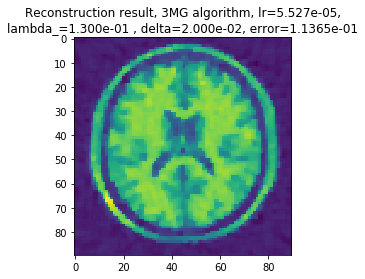

In [62]:
def MMMG(lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000, 
         stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        if itr==0:
            D_n = -grad
        else:
            D_n = np.concatenate((-grad, x_n - x_old), axis=1)
        D_n = D_n.reshape(N,-1)
        matrix_shape = D_n.shape[1]
        sub_A_x = lambda x : ((H@D_n).T.dot((H@D_n)) + lambda_ * (G@D_n).T.dot(big_delta(G.dot(x_n),
                                                                                    delta).dot((G@D_n)))).dot(x)
        A = LinearOperator((matrix_shape,matrix_shape),matvec = sub_A_x, rmatvec = sub_A_x)
        b = D_n.T@grad
        x_n1 = x_n - D_n@bicg(A, b, tol=1e-3)[0].reshape(-1, 1)
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append(error)
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_old = x_n.copy()
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, error, history
    
x_rec_MMMG, _, history_MMMG = MMMG()
rec_error_MMMG = np.linalg.norm((x - x_rec_MMMG).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_MMMG_view = x_rec_MMMG.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_MMMG_view)
ax.set_title('Reconstruction result, 3MG algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error_MMMG))

## 3.4 Block-coordinate MM quadratic algorithm

We will consider here the following selection for the block index j:$$(\forall k \in \mathbb{N}) \quad j=\operatorname{mod} (k-1, J)+1$$
Then the pixels indexes $n \in \mathbb{J}_{j}$ are updated, with :$$\mathbb{J}_{j}=\left\{N_{j}(j-1)+1, \ldots, j N_{j}\right\}$$

Error : 8.4734e+01 | value of f : 28886.6545 | rec_error : 90.4758
Error : 4.0674e+01 | value of f : 189231.3529 | rec_error : 212.4630
Error : 1.0458e+01 | value of f : 80974.7473 | rec_error : 103.7385
Error : 5.1443e+00 | value of f : 45567.7205 | rec_error : 66.9612
Error : 2.9794e+00 | value of f : 28336.9391 | rec_error : 45.4162
Error : 5.7191e+00 | value of f : 16418.4760 | rec_error : 25.6178
Error : 2.1788e+00 | value of f : 11285.4337 | rec_error : 16.9251
Error : 1.1552e+00 | value of f : 8434.5836 | rec_error : 10.8554
Error : 1.0978e-01 | value of f : 7278.6496 | rec_error : 7.9621
Error : 1.1739e+00 | value of f : 6317.7724 | rec_error : 5.2898
Error : 1.3155e-01 | value of f : 5989.3629 | rec_error : 4.5067
Error : 1.8052e-01 | value of f : 5802.3433 | rec_error : 4.1337
Error : 5.8931e-02 | value of f : 5734.7284 | rec_error : 4.0226
Error : 9.6657e-02 | value of f : 5701.8888 | rec_error : 3.9838
Error : 2.3627e-02 | value of f : 5698.1971 | rec_error : 3.9810
Error :

Text(0.5, 1.0, 'Reconstruction result, Block Coordinate algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, error=1.1369e-01')

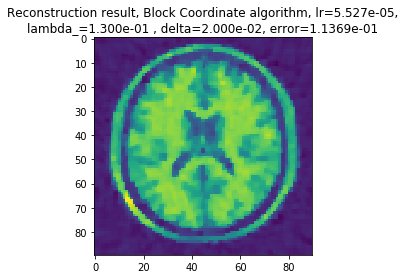

In [63]:
def BCMM(nb_blocks=6, lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000, 
         stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    N_j = N//nb_blocks
    block_size = [N_j for _ in range(nb_blocks)]
    if N_j*nb_blocks != N:
        block_size += [N - nb_blocks*N_j]
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        block_idx = itr%(nb_blocks)
        N_j = block_size[block_idx]
        H_j = H[:,N_j*block_idx:(block_idx+1)*N_j]
        G_j = G[:,N_j*block_idx:(block_idx+1)*N_j]
        x_n_j = x_n[N_j*block_idx:(block_idx+1)*N_j]
        grad = grad_f(x_n)[N_j*block_idx:(block_idx+1)*N_j]
        A_x = lambda x : (H_j.T.dot(H_j.dot(x)) + lambda_ * G_j.T.dot(big_delta(G_j.dot(x_n_j),
                                                                                delta).dot(G_j.dot(x))))
        A = LinearOperator((N_j,N_j),matvec = A_x, rmatvec = A_x)
        mask = np.zeros(x_n.shape)
        mask[N_j*block_idx:(block_idx+1)*N_j] = bicg(A, grad, tol=1e-3)[0].reshape(-1, 1)
        x_n1 = x_n - mask
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append(error)
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, error, history
    
x_rec_BCMM, _, history_BCMM = BCMM(9)
rec_error_BCMM = np.linalg.norm((x - x_rec_BCMM).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_BCMM_view = x_rec_BCMM.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_BCMM_view)
ax.set_title('Reconstruction result, Block Coordinate algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error_BCMM))

Let's try to find the best value for J=nb_blocks :

In [99]:
def golden_section_search(function, x, nb_blocks_range, tol=1e-8, it_max=100, name='MM_quad'):
    nb_blocks0, nb_blocks3 = nb_blocks_range
    error = []
    nb_blocks = []
    golden_section_gamma = [(3 - np.sqrt(5))/2 , (np.sqrt(5)-1)/2]
    best_nb_blocks = {}
    it = 0
    converged = False
    while not converged and (it < it_max):
        it=it+1
        nb_blocks1 = int(nb_blocks0 + golden_section_gamma[0] * (nb_blocks3 - nb_blocks0))
        nb_blocks2 = int(nb_blocks0 + golden_section_gamma[1] * (nb_blocks3 - nb_blocks0))

        x_rec_1, _, _ = function(nb_blocks1)
        rec_error1 = np.linalg.norm(x-x_rec_1, ord='fro')/np.linalg.norm(x, ord='fro')
        nb_blocks.append(nb_blocks1)
        error.append(rec_error1)

        x_rec_2, _, _ = function(nb_blocks2)
        rec_error2 = np.linalg.norm(x-x_rec_2, ord='fro')/np.linalg.norm(x, ord='fro')
        nb_blocks.append(nb_blocks2)
        error.append(rec_error2)

        converged = (abs(rec_error2 - rec_error1)<tol)
        if rec_error1 < rec_error2 : 
            nb_blocks0, nb_blocks3 = nb_blocks0, nb_blocks2
        else: 
            nb_blocks0, nb_blocks3 = nb_blocks1, nb_blocks3
    if converged :
        print('optimal value reached for : nb_blocks = {:.2e}'.format(nb_blocks1))
    end = time.time()

    x_rec, error, history = function(nb_blocks1)
    rec_error = np.linalg.norm(x-x_rec, ord='fro')/np.linalg.norm(x, ord='fro')
    fg, ax = plt.subplots(1,1)
    ax.imshow(x_rec_BCMM_view)
    ax.legend()
    ax.set_title('Reconstruction result, {2} algorithm, \nnb_blocks={0:.2e}, error={1:.4f}'.format(
                                                                            nb_blocks1, rec_error, name))

53.129375211206764
5.899024989966077
3.556410697005644
17.656565803585686
5.349728900516114
3.3084042554443913
14.010923493455921
5.707241671270641
3.440519583198387
10.233086960428265
5.002426090481077
3.502638050396074
7.891005412667141
4.651172676722722
3.595122517752904
7.253297011433514
2.919683529292352
3.407466803495556
3.7921560725072068
3.8126264847662696
3.0302908200526684
4.2741270408111625
3.3780727441535543
3.022873128535845
7.639292798622512
3.9764870475805614
3.358610655109676
8.117271964803166
3.940419184175235
2.335063643198725
10.783711592891267
3.6382570401514416
3.61243937540143
11.979161181466791
2.888925194861228
3.6028571381902976
12.25050371481458
3.4373385848844253
4.474789419477363
62.071169139283754
5.284948701613312
4.136118861439566
32.800724963115925
3.510080927067719
3.049715263392204
17.327763629220758
2.934620673671488
2.1715729335350384
7.035792650815897
2.0684134573386515
1.755243370461737
6.010791528886659
1.5120636568291044
1.3225975546639768
5.2374

1.574332257207711
2.2860547312241386
7.529127752283408
3.744984180931902
3.437073030061693
8.0354595180311
7.323555685101531
3.1886619558538376
1.5678295220453577
1.5869072578474301
2.6215209376816957
5.081583085536057
1.9763564447604913
15.878249593495667
10.453203314505798
6.914257805927947
3.651633595484688
1.6730823415886504
1.5787862083091249
2.062293315397615
1.66730850133004
1.4798182010757868
2.8624333764870924
4.2232325957675405
4.998519706871064
3.6800313220391385
10.357406736230173
3.1975529324194287
3.075646263837583
1.7775855765208657
1.11895627367577
0.8815726725944746
0.5620270113594785
0.4773387553230872
0.8769488262444574
1.1506670919618038
1.637351255693474
1.5024578201642043
1.3446802523724544
1.4808100955158696
23.51752392805912
0.9907815793543854
0.536696271432387
0.7949476915930423
0.9567873908573742
0.832830753938203
0.9330257052260331
1.3155154687109836
1.0899067508581572
0.6686324394907367
0.25564430336576754
0.4645630544293
0.8714499175983025
1.197681003608648

0.2960277829699217
0.12520915436043598
0.35061342726689676
0.11272989141107087
0.14008656443970174
0.09068614928814836
0.23939109879407544
0.18430973396490455
0.1989309347297794
0.10480853466119529
0.03530497943796848
0.1456713255271837
0.14355183048474873
0.15460804875852363
0.10291250789447577
0.05883349715634388
0.024948682910483123
0.16596604311343952
0.11965976547418608
0.12391877839933307
0.07931723895885985
0.02559837427673447
0.1843131539299664
0.16070351623196016
0.07621192484631534
0.08491612993549176
0.04471367266652313
0.01570583137359724
0.10712714870900757
0.11811392609596293
0.13591483902803894
0.09038760323185074
0.027450417412671835
0.006446650864940299
0.1026124282991118
0.07837010620432013
0.10451104785223155
0.07561150584074379
It took 1000 iterations and 57.81 seconds to converge.
65.05134315060855
20.605329347752043
16.374739867254153
10.85748449918984
6.847582836769753
7.665341320695702
11.518994956764983
13.587834297242633
16.124699206946193
128.80785394684318
2

0.23308279199522075
0.0753516778845282
0.12126674676238605
0.0583082512667455
0.16647351961474577
0.11028307891203547
0.16014618462005992
0.08340489190557292
0.06558774143902102
0.017651186442185753
0.08513295281940657
0.12822252827133881
0.08172792685049363
0.06209095930010104
0.0402055737345231
0.20718161818284703
0.06061223412660349
0.10261438578734496
0.04255120340669282
0.05158068432149871
0.012702356538835296
0.09127013120638754
0.05599428237810168
0.06366401752163203
0.03628418475466756
0.04224213915171557
0.10855975666169417
It took 1000 iterations and 58.06 seconds to converge.
65.29460626283506
29.834907297914416
26.9046075541397
13.80552515820912
12.361985237358002
13.956799455369255
14.699969782791069
57.48275394383448
24.991284204774484
15.29472387011755
12.161910520330503
9.757211455301517
17.49505325985861
19.582518098387084
14.153759543480449
12.781732626006365
13.707269376698049
9.302083941390482
6.3235517124271965
4.068744974595671
5.285821747231802
25.75762037366759


0.0060728755608476116
0.004342660603444752
0.0010794326269976148
0.007097458292726778
0.004897944599835092
0.0033868899009396863
0.0016969798789100354
0.006437393216057122
0.003510108241513811
0.004991042967072323
0.002051323700337793
0.00392076931553195
0.003431089745076393
0.0018930918486695781
It took 1000 iterations and 61.78 seconds to converge.
62.292081393656616
51.468407860118035
27.621184025531672
25.94125361113601
14.54909870710052
52.483909759578594
16.85673949857995
11.583170608379582
12.650078531247297
8.074198212694904
13.52242820689269
15.319098854340096
8.841497577369955
4.612522037015521
15.06249849240314
6.32239090914773
4.73298308579037
6.209577131899256
2.167662530877476
2.6065911239461914
1.9308579827672585
3.817798788871354
4.157758177683523
5.886365499351453
1.7421749085567781
1.2240798272013869
3.333098934462465
1.347440270608237
0.6891640090756793
2.100006244808117
0.8625835368833217
1.7151388787906952
0.7156686708276905
2.200450290285274
1.064129101775853
1.47

0.0013471888831291493
0.006873634201242738
0.0020589189548545013
0.004342068398676601
0.0017362483213320147
0.005533077578928677
0.002147451909054469
0.0038710696173115404
0.0014371506190712239
0.004500666730451264
It took 1000 iterations and 62.10 seconds to converge.
68.39907554195763
46.88406855489174
29.02281398173286
19.69658951620374
13.514535583386337
32.61714095555072
9.496098152204848
11.378250887178377
11.83428939031464
11.91190699883151
12.488016279248422
8.408142896446666
4.389650447312133
10.035173172571165
5.06069666850486
8.070106935579542
3.4438446765244497
4.79048019974799
2.1534276291155963
2.39580402086443
4.016218855871367
6.722628817700151
1.699592392403757
1.2998013385193783
0.8804720627232874
0.6421877075450889
0.7266555206907026
1.1602055674658436
1.0322861394911402
0.513074308773579
0.2273786953345917
1.4221461446967318
0.9652858201654246
0.19973962239791224
0.18257520462857782
0.22960647803533454
1.2248850060055052
0.2504579545868544
0.27778404852549554
0.7558

0.003510108241513811
0.004991042967072323
0.002051323700337793
0.00392076931553195
0.003431089745076393
0.0018930918486695781
It took 1000 iterations and 62.38 seconds to converge.
68.39907554195763
46.88406855489174
29.02281398173286
19.69658951620374
13.514535583386337
32.61714095555072
9.496098152204848
11.378250887178377
11.83428939031464
11.91190699883151
12.488016279248422
8.408142896446666
4.389650447312133
10.035173172571165
5.06069666850486
8.070106935579542
3.4438446765244497
4.79048019974799
2.1534276291155963
2.39580402086443
4.016218855871367
6.722628817700151
1.699592392403757
1.2998013385193783
0.8804720627232874
0.6421877075450889
0.7266555206907026
1.1602055674658436
1.0322861394911402
0.513074308773579
0.2273786953345917
1.4221461446967318
0.9652858201654246
0.19973962239791224
0.18257520462857782
0.22960647803533454
1.2248850060055052
0.2504579545868544
0.27778404852549554
0.7558116338577174
0.08630012914466817
0.15438997902116808
0.312543946827306
0.5083689207378423

No handles with labels found to put in legend.


It took 1000 iterations and 62.03 seconds to converge.


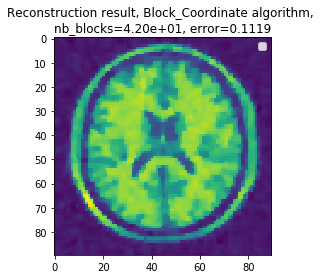

In [100]:
golden_section_search(BCMM, x, nb_blocks_range=[1,1000], tol=1e-6, it_max=100, name='Block_Coordinate')

## 3.6 Comparison of the methods

First, compare the methods as they are right now :

In [ ]:
functions = [grad_desc, MM_quad, MMMG, BCMM]

fg, ax = plt.subplots(2,2,figsize=(16,16))
for index, function in enumerate(functions):
    print('-'*70,' Function ', index+1)
    beg = time.time()
    x_rec, _, history = function(max_iter=10000, records=False)
    end = time.time()
    nb_itr = len(history)
    exec_time = end - beg
    rec_error = np.linalg.norm((x - x_rec).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
    x_rec_view = x_rec.reshape((90,90), order='F')
    ax[index//2][index%2].imshow(x_rec_view)
    ax[index//2][index%2].set_title('Reconstruction result, Block Coordinate algorithm, lr={0:.3e},'.format(learning_rate)
                 +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error)
                 +'\n{0} iterations, {1:.3f} seconds'.format(nb_itr, exec_time))

----------------------------------------------------------------------  Function  1
----------------------------------------------------------------------  Function  2
----------------------------------------------------------------------  Function  3
----------------------------------------------------------------------  Function  4


---

Then, let's compare the approaches using the gradient criterion defined as : $$\left\|\nabla f\left(x_{k}\right)\right\| \leq \sqrt{N} \times 10^{-4}$$

In [ ]:
fg, ax = plt.subplots(2,2,figsize=(16,16))
for index, function in enumerate(functions):
    print('-'*70,' Function ', index+1)
    beg = time.time()
    x_rec, _, history = function(max_iter=10000, records=False, stopping='gradient')
    end = time.time()
    nb_itr = len(history)
    exec_time = end - beg
    rec_error = np.linalg.norm((x - x_rec).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
    x_rec_view = x_rec.reshape((90,90), order='F')
    ax[index//2][index%2].imshow(x_rec_view)
    ax[index//2][index%2].set_title('Reconstruction result, Block Coordinate algorithm, lr={0:.3e},'.format(learning_rate)
                 +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error)
                 +'\n{0} iterations, {1:.3f} seconds'.format(nb_itr, exec_time))

---

Finally let's optimize the fastest method over $(\lambda, \delta)$ when minimizing the Signal to Noise Ratio defined as : $$\mathrm{SNR}=10 \log _{10}\left(\|\bar{x}\|^{2} /\|\bar{x}-\widehat{x}\|^{2}\right)$$

In [ ]:
fg, ax = plt.subplots(2,2,figsize=(16,16))
beg = time.time()
x_rec, _, history = function(max_iter=10000, records=False, error_type='SNR') # fill in the fastest function
end = time.time()
nb_itr = len(history)
exec_time = end - beg
rec_error = np.linalg.norm((x - x_rec).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_view = x_rec.reshape((90,90), order='F')
ax[index//2][index%2].imshow(x_rec_view)
ax[index//2][index%2].set_title('Reconstruction result, Block Coordinate algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error)
             +'\n{0} iterations, {1:.3f} seconds'.format(nb_itr, exec_time))